# Fit LDA ensemble

see: https://radimrehurek.com/gensim/auto_examples/tutorials/run_ensemblelda.html

In [1]:
import pickle
import pandas as pd
from gensim.models import LdaModel
from gensim.models import EnsembleLda
from gensim.models.ldamulticore import LdaMulticore
import numpy as np
import statistics
import os
from matplotlib import pyplot as plt 

%matplotlib inline

In [2]:
DATA_PATH = '../data'
MODELS_PATH = '../models'

## Load dictionary and corpus
Load the dictionary, tokenized train- and validate-corpus.

In [3]:
# Load the datasets for Computation and Language
with open(os.path.join(DATA_PATH, 'dictionary_cscl.pickle'), 'rb') as handle:
    dictionary_cscl = pickle.load(handle)

with open(os.path.join(DATA_PATH, 'corpus_train_cscl.pickle'), 'rb') as handle:
    corpus_train_cscl = pickle.load(handle)

with open(os.path.join(DATA_PATH, 'corpus_validate_cscl.pickle'), 'rb') as handle:
    corpus_validate_cscl = pickle.load(handle)

with open(os.path.join(DATA_PATH, 'corpus_test_cscl.pickle'), 'rb') as handle:
    corpus_test_cscl = pickle.load(handle)

# Load the datasets for Gravitational Waves
with open(os.path.join(DATA_PATH, 'dictionary_gw.pickle'), 'rb') as handle:
    dictionary_gw = pickle.load(handle)

with open(os.path.join(DATA_PATH, 'corpus_train_gw.pickle'), 'rb') as handle:
    corpus_train_gw = pickle.load(handle)

with open(os.path.join(DATA_PATH, 'corpus_validate_gw.pickle'), 'rb') as handle:
    corpus_validate_gw = pickle.load(handle)

with open(os.path.join(DATA_PATH, 'corpus_test_gw.pickle'), 'rb') as handle:
    corpus_test_gw = pickle.load(handle)

## Fit ensemble LDA

### Training

In [27]:
# parameters passed to the fit_ensemble_lda function
topic_model_class = LdaModel
ensemble_workers = 16
num_models = ensemble_workers
distance_workers = 16
num_topics = 50
passes = 8
chunksize = 20000

In [28]:
def fit_ensemble_lda(dictionary, corpus):
    """A function to train an ensemble LDA"""
    ensemble = EnsembleLda(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        passes=passes,
        num_models=num_models,
        topic_model_class=topic_model_class,
        ensemble_workers=ensemble_workers,
        distance_workers=distance_workers,
        chunksize=chunksize
    )
    return(ensemble)

### Optimize the epsilon parameter

Parameters for optimizing the $\epsilon$ clustering parameter

In [29]:
max_runs = 5  # the number of times the LDA ensemble will be trained
steps = 25  # the number of steps covering the epsilon range

In [30]:
def get_shape_range(ensemble, steps):
    """Get the range of epsilon values for this ensemble"""
    shape = ensemble.asymmetric_distance_matrix.shape
    without_diagonal = ensemble.asymmetric_distance_matrix[~np.eye(shape[0], dtype=bool)].reshape(shape[0], -1)
    return(np.linspace(without_diagonal.min(), without_diagonal.max(), num=steps))

In [31]:
def compute_perplexity_for_ensemble(dictionary, corpus_train, corpus_validate, max_runs, steps):
    """
    Trains LDA ensemble 'max_run' times, each time with with 'steps' different values of epsilon, return perplexity values.
    @return: a list of dataframes, one dataframe for each run. Each row in the dataframe has 'k' num stable topics, 'eps' clustering parameter epsilon, 'val' perplexity value.
    """
    perplexity = []
    for run in range(max_runs):
        print(f"Run {run + 1} / {max_runs}")
        eps = []
        num_topics_eps = []
        px = []
        ensemble = fit_ensemble_lda(dictionary, corpus_train)
        shape_range = get_shape_range(ensemble, steps)
        for val in shape_range:
            ensemble.recluster(eps=val)
            len_topics = len(ensemble.get_topics())
            num_topics_eps.append(len_topics)
            eps.append(val)
            if len_topics > 1:
                # compute the perplexity for this value of epsilon
                log_perplexity = ensemble.log_perplexity(corpus_validate)
                perplexity_eps = np.exp(-log_perplexity)
                px.append(perplexity_eps)
#                print(f"eps: {val} stable number of topics: {len_topics}, perplexity: {perplexity_eps}")
            else:
                # there's 1 or no stable topics, perplexity is infinite
                px.append(np.inf)
        perplexity.append(pd.DataFrame.from_dict({'k': num_topics_eps, 'eps': eps, 'val': px}))
    return(perplexity)


### Compute perplexity by value of $\epsilon$ clustering parameter for the gravitational waves dataset

In [32]:
%%time

perplexity_gw = compute_perplexity_for_ensemble(dictionary_gw, corpus_train_gw, corpus_validate_gw, max_runs, steps)

Run 1 / 5
Run 2 / 5
Run 3 / 5
Run 4 / 5
Run 5 / 5
CPU times: user 1min 18s, sys: 3.48 s, total: 1min 21s
Wall time: 4min 6s


### Compute perplexity by value of $\epsilon$ clustering parameter for the computation and language dataset

In [18]:
%%time

perplexity_cscl = compute_perplexity_for_ensemble(dictionary_cscl, corpus_train_cscl, corpus_validate_cscl, max_runs, steps)

Run 1 / 5
Run 2 / 5
Run 3 / 5
Run 4 / 5
Run 5 / 5
CPU times: user 4min 17s, sys: 3.69 s, total: 4min 21s
Wall time: 7min 34s


## Plot the perplexity curves

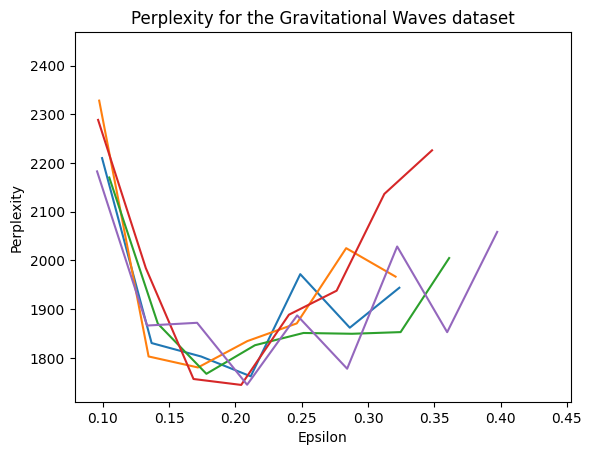

In [19]:
for run in range(max_runs):
    plt.plot(perplexity_gw[run].eps, perplexity_gw[run].val)
plt.title("Perplexity for the Gravitational Waves dataset")
plt.xlabel("Epsilon")
plt.ylabel("Perplexity")
plt.show()

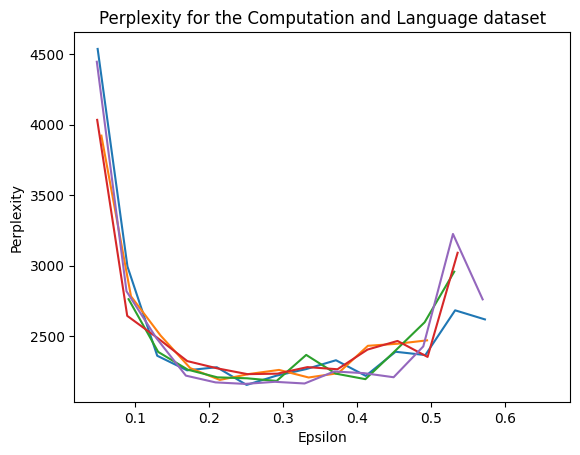

In [20]:
for run in range(max_runs):
    plt.plot(perplexity_cscl[run].eps, perplexity_cscl[run].val)
plt.title("Perplexity for the Computation and Language dataset")
plt.xlabel("Epsilon")
plt.ylabel("Perplexity")
plt.show()

### Find the best $\epsilon$ value: mode of list of best values for each run

In [21]:
def find_best_eps(max_runs, perplexity):
    best_eps_runs = []
    for run in range(max_runs):
        best_eps_runs.append(perplexity[run].sort_values('val', ascending=True).iloc[0]['eps'])
    best_eps = statistics.mode(best_eps_runs)
    return(best_eps)


In [22]:
best_eps_gw = find_best_eps(max_runs, perplexity_gw)
print(f"Best epsilon value for the Gravitational Waves dataset after {max_runs} runs is: {best_eps_gw}")

best_eps_cscl = find_best_eps(max_runs, perplexity_cscl)
print(f"Best epsilon value for the Computation and Language dataset after {max_runs} runs is: {best_eps_cscl}")

Best epsilon value for the Gravitational Waves dataset after 5 runs is: 0.21149948524915269
Best epsilon value for the Computation and Language dataset after 5 runs is: 0.25082963643768913


## Gravitation waves topics
Refit the model, with best $\epsilon$, on the test dataset

In [23]:
ensemble_gw = fit_ensemble_lda(dictionary_gw, corpus_test_gw)
ensemble_gw.recluster(eps=best_eps_gw, min_samples=2, min_cores=2)
print(f"Found {len(ensemble_gw.print_topics())} stable topics for the Gravitational Waves dataset")
ensemble_gw.print_topics(num_words=5)

Found 11 stable topics for the Gravitational Waves dataset


[(0,
  '0.018*"model" + 0.012*"spectrum" + 0.010*"phase" + 0.009*"inflation" + 0.009*"transition"'),
 (1,
  '0.036*"hole" + 0.035*"black" + 0.012*"theory" + 0.010*"mass" + 0.009*"field"'),
 (2,
  '0.031*"ray" + 0.024*"gamma" + 0.020*"burst" + 0.014*"emission" + 0.013*"energy"'),
 (3,
  '0.018*"detector" + 0.015*"signal" + 0.014*"data" + 0.013*"noise" + 0.008*"detection"'),
 (4,
  '0.016*"noise" + 0.015*"frequency" + 0.013*"detector" + 0.011*"interferometer" + 0.009*"signal"'),
 (5,
  '0.043*"pulsar" + 0.023*"timing" + 0.010*"array" + 0.010*"noise" + 0.009*"data"'),
 (6,
  '0.016*"binary" + 0.012*"order" + 0.011*"waveform" + 0.011*"newtonian" + 0.011*"orbit"'),
 (7,
  '0.043*"star" + 0.035*"neutron" + 0.017*"merger" + 0.016*"mass" + 0.012*"binary"'),
 (8,
  '0.027*"mode" + 0.023*"star" + 0.015*"neutron" + 0.013*"binary" + 0.010*"frequency"'),
 (9,
  '0.016*"background" + 0.016*"polarization" + 0.015*"cmb" + 0.014*"mode" + 0.011*"signal"'),
 (10,
  '0.035*"field" + 0.034*"magnetic" + 0.0

### Save the model

In [24]:
with open(os.path.join(MODELS_PATH, 'ensemble_gw.pickle'), 'wb') as handle:
    pickle.dump(ensemble_gw, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Computation and Language topics
Refit the model, with best $\epsilon$, on the test dataset

In [25]:
ensemble_cscl = fit_ensemble_lda(dictionary_cscl, corpus_test_cscl)
ensemble_cscl.recluster(eps=best_eps_cscl, min_samples=2, min_cores=2)
print(f"Found {len(ensemble_cscl.print_topics())} stable topics for the Computation and Language dataset")
ensemble_cscl.print_topics(num_words=5)

Found 15 stable topics for the Computation and Language dataset


[(0,
  '0.043*"translation" + 0.016*"machine" + 0.010*"data" + 0.009*"nmt" + 0.009*"neural"'),
 (1,
  '0.045*"question" + 0.024*"answer" + 0.012*"answering" + 0.011*"task" + 0.009*"reasoning"'),
 (2,
  '0.035*"llm" + 0.010*"task" + 0.009*"large" + 0.007*"performance" + 0.007*"prompt"'),
 (3,
  '0.042*"speech" + 0.012*"data" + 0.010*"task" + 0.009*"recognition" + 0.009*"training"'),
 (4,
  '0.034*"bias" + 0.014*"gender" + 0.008*"data" + 0.006*"task" + 0.006*"based"'),
 (5,
  '0.029*"dialogue" + 0.012*"task" + 0.009*"state" + 0.008*"system" + 0.007*"human"'),
 (6,
  '0.021*"style" + 0.011*"knowledge" + 0.010*"task" + 0.009*"transfer" + 0.008*"text"'),
 (7,
  '0.016*"evaluation" + 0.014*"human" + 0.013*"metric" + 0.011*"task" + 0.010*"summarization"'),
 (8,
  '0.048*"topic" + 0.012*"approach" + 0.012*"document" + 0.011*"method" + 0.007*"word"'),
 (9,
  '0.053*"event" + 0.010*"argument" + 0.010*"extraction" + 0.009*"task" + 0.007*"method"'),
 (10,
  '0.034*"code" + 0.013*"task" + 0.008*"ge

### Save the model

In [26]:
with open(os.path.join(MODELS_PATH, 'ensemble_cscl.pickle'), 'wb') as handle:
    pickle.dump(ensemble_cscl, handle, protocol=pickle.HIGHEST_PROTOCOL)